In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip uninstall -y kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10


In [3]:
 ! pip install kaggle

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f1a8dddc5a31beeb50357ff7bd8d6e0ddf9a4766e9f8c481a7e2757169619f44
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle


In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luzanikita","key":"7b96c91cdf354e51e45c30a95bf4821c"}'}

In [5]:
! mkdir /root/.kaggle/

In [6]:
! cp kaggle.json /root/.kaggle/

In [7]:
 ! chmod 600 /root/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c newsclass01

100% 8.38G/8.39G [03:16<00:00, 39.1MB/s]
100% 8.39G/8.39G [03:17<00:00, 45.7MB/s]


In [ ]:
!unzip newsclass01.zip

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 5.3MB/s 
     |████████████████████████████████| 3.2MB 13.5MB/s 
     |████████████████████████████████| 890kB 41.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=078a6c774edd56a58cd90b2165e2d99086212821990298f463b8810efa1fc001
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [12]:
import pandas as pd

In [275]:
dataset = pd.read_csv("train.csv")
dataset.head()

,Id,title,text,images,source
0,1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN,5
1,2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
2,5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
3,9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN,3
4,10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0


# Тренируем модель на картинках

In [276]:
idx = dataset["images"].dropna().index
dataset = dataset.loc[idx]
dataset

,Id,title,text,images,source
1,2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
2,5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
4,10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0
5,11,"Берні Сандерс: яку ""політичну революцію"" він о...",Сенатор з Вермонту Берні Сандерс який називає ...,"a565352e-be96-4a93-a3a8-cbc2bfcce7fd.png,b2603...",0
10,16,Як локдаун може допомогти дітям з вивченням ін...,В Україні локдаун і школи зачинені десь місяць...,"da25653f-056a-44c2-953e-fb98f996bc5f.png,445a5...",5
...,...,...,...,...,...
16164,32342,"Чому неякісні дитячі іграшки, конфісковані мит...",За даними Всесвітньої організації охорони здор...,"2446f6ad-6829-4bcb-8e81-7b0859c94a8b.png,d9488...",5
16167,32346,"Програма уряду Шмигаля: що з економікою, зароб...",Депутати мають розглянути її 18 червня.\nНа по...,"e1d55e49-d044-48ac-aefe-be230d3f39f9.png,e8309...",0
16169,32354,"У МОЗ заявили, що встигнуть використати вакцин...",Керівник експертної групи з питань імунопрофіл...,487a53f0-85d7-4232-b968-7a2323b16ab7.png,1
16175,32369,Лижі: як підготувати дитину до відпустки та че...,Якщо батькам подобається кататися на лижах – ц...,"7770c665-825b-433a-b63e-f6e0ebe7f4cb.png,66866...",5


In [20]:
! pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=74212b639f1603e6cbd5e308616e1a49cafbdabe01d8397ead6facbc34bf691a
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

(512, 512, 3)


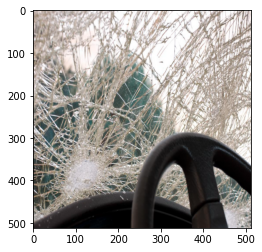

In [39]:
path = os.path.join("/content/images/images", dataset.loc[109, "images"])
img = cv2.imread(path)
print(img.shape)
plt.imshow(img)

In [40]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
from efficientnet_pytorch import EfficientNet

In [87]:
def prepare_model(n_classes):
    model = build_net(n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005)

    return model, criterion, optimizer, scheduler

def build_net(n_classes):
    model = EfficientNet.from_pretrained('efficientnet-b4').to(device)
    num_features = model._fc.in_features

    for param in model.parameters():
        param.requires_grad = False   
        
    top_head = create_head(num_features , n_classes)
    model._fc = top_head
    return model
  
def create_head(num_features, number_classes, dropout_prob=0.5, activation_func=nn.ReLU):
    features_lst = [num_features , num_features // 2 , num_features // 4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob != 0:
            layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers).to(device)

In [337]:
def train(model, dataloaders, criterion, optimizer, save_dir, num_epochs=5, th=0.5):

    valid_loss_min = np.Inf
    loss_history = {"train": [], "val": []}
    f1_history = {"train": [], "val": []}
    
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        result = []
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_f1 = 0.0    
                
            for data, target in dataloaders[phase]:
                data, target = data.to(device), target.to(device)

                with torch.set_grad_enabled(phase=="train"):
                    output = model(data)
                    loss = criterion(output, target)
                    preds = output.argmax(-1)

                    if phase=="train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * data.size(0)
                running_f1 += f1_score(
                    target.to("cpu").to(torch.int).numpy(),
                    preds.to("cpu").to(torch.int).numpy(),
                    zero_division=1,
                    average="macro"
                ) * data.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / len(dataloaders[phase].dataset)   

            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(epoch_f1)

            result.append(
                "{} Loss: {:.4f} F1: {:.4f}".format(
                    phase, epoch_loss, epoch_f1
                )
             )

            if phase == "val":
                network_learned = epoch_loss < valid_loss_min
                if network_learned:
                    valid_loss_min = epoch_loss
                    save_path = os.path.join(save_dir, f"model_epoch_{epoch}.pt")
                    torch.save(model.state_dict(), save_path)
                    print("Improvement-Detected, save-model")

        print(*result, sep="\n")
    
    return loss_history, f1_history

In [226]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [227]:
train_annotation = dataset.sample(frac=0.8)
val_annotation = dataset.drop(train_dataset.index)
train_annotation.shape, val_annotation.shape

((5778, 5), (1445, 5))

In [228]:
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


class ImgDataset(Dataset):
    def __init__(self, annotations, root_dir="/content/images/images", transform=None, n_classes=7):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
        self.n_classes = n_classes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        fname = self.annotations.iloc[idx]["images"]
        if "," in fname:
            fname = fname.split(",")[0]
        else:
            fname = fname
        
        img_name = os.path.join(
            self.root_dir,
            fname
        )
        image = cv2.imread(img_name)
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        target = self.annotations.iloc[idx]["source"]
        # target = (np.arange(self.n_classes) == self.annotations.iloc[idx]["source"]).astype(np.float32)
        # target = torch.from_numpy(target).to(torch.int64)

        if self.transform:
            image = TF.to_pil_image(image)
            image = self.transform(image)
        
        return image, target

In [229]:
def prepare_datasets(train_annotation, val_annotation, img_dir="/content/images/images", batch_size=24):
    data_transforms = {
        "train":
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        "val":
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
    }
    image_datasets = {
        "train": ImgDataset(train_annotation, img_dir, data_transforms["train"]),
        "val": ImgDataset(val_annotation, img_dir, data_transforms["val"])
    }
    dataloaders = {
        "train": DataLoader(image_datasets["train"], drop_last=True, batch_size=batch_size),
        "val": DataLoader(image_datasets["val"], drop_last=True, batch_size=batch_size)
    }
    return image_datasets, dataloaders

In [230]:
image_datasets, dataloaders = prepare_datasets(
    train_annotation, 
    val_annotation
)

In [231]:
input, target = next(iter(dataloaders["train"]))
input.shape, target.shape

(torch.Size([24, 3, 512, 512]), torch.Size([24]))

In [232]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [233]:
model, criterion, optimizer, scheduler = prepare_model(image_datasets["train"].n_classes)

Loaded pretrained weights for efficientnet-b4


In [234]:
weights_dir = "/content/gdrive/MyDrive/img_weights"

In [235]:
from tqdm import tqdm

In [250]:
loss_history, f1_history = train(
    model, dataloaders, criterion, optimizer, weights_dir, num_epochs=20
)







  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 0








  0%|          | 1/240 [00:00<02:58,  1.34it/s]





  1%|          | 2/240 [00:01<02:55,  1.35it/s]





  1%|▏         | 3/240 [00:02<02:53,  1.37it/s]





  2%|▏         | 4/240 [00:02<02:50,  1.38it/s]





  2%|▏         | 5/240 [00:03<02:49,  1.39it/s]





  2%|▎         | 6/240 [00:04<02:47,  1.40it/s]





  3%|▎         | 7/240 [00:05<02:46,  1.40it/s]





  3%|▎         | 8/240 [00:05<02:46,  1.39it/s]





  4%|▍         | 9/240 [00:06<02:46,  1.39it/s]





  4%|▍         | 10/240 [00:07<02:45,  1.39it/s]





  5%|▍         | 11/240 [00:07<02:46,  1.37it/s]





  5%|▌         | 12/240 [00:08<02:45,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:44,  1.38it/s]





  6%|▌         | 14/240 [00:10<02:42,  1.39it/s]





  6%|▋         | 15/240 [00:10<02:43,  1.38it/s]





  7%|▋         | 16/240 [00:11<02:41,  1.39it/s]





  7%|▋         | 17/240 [00:12<02:40,  1.39it/s]





  8%|▊         | 18/240 [00:13<02:42,  1.37it/s]





  8%|▊         | 19/240 [00:13<

Improvement-Detected, save-model
train Loss: 0.7435 F1: 0.6699
val Loss: 0.6317 F1: 0.7644
Epoch: 1








  0%|          | 1/240 [00:00<02:49,  1.41it/s]





  1%|          | 2/240 [00:01<02:50,  1.39it/s]





  1%|▏         | 3/240 [00:02<02:50,  1.39it/s]





  2%|▏         | 4/240 [00:02<02:49,  1.40it/s]





  2%|▏         | 5/240 [00:03<02:48,  1.39it/s]





  2%|▎         | 6/240 [00:04<02:47,  1.40it/s]





  3%|▎         | 7/240 [00:05<02:47,  1.39it/s]





  3%|▎         | 8/240 [00:05<02:46,  1.39it/s]





  4%|▍         | 9/240 [00:06<02:45,  1.40it/s]





  4%|▍         | 10/240 [00:07<02:45,  1.39it/s]





  5%|▍         | 11/240 [00:07<02:44,  1.39it/s]





  5%|▌         | 12/240 [00:08<02:43,  1.40it/s]





  5%|▌         | 13/240 [00:09<02:42,  1.40it/s]





  6%|▌         | 14/240 [00:10<02:42,  1.39it/s]





  6%|▋         | 15/240 [00:10<02:47,  1.34it/s]





  7%|▋         | 16/240 [00:11<02:45,  1.36it/s]





  7%|▋         | 17/240 [00:12<02:43,  1.36it/s]





  8%|▊         | 18/240 [00:13<02:42,  1.36it/s]





  8%|▊         | 19/240 [00:13<

train Loss: 0.7294 F1: 0.6687
val Loss: 0.6445 F1: 0.7507
Epoch: 2








  0%|          | 1/240 [00:00<02:51,  1.40it/s]





  1%|          | 2/240 [00:01<02:51,  1.39it/s]





  1%|▏         | 3/240 [00:02<02:53,  1.36it/s]





  2%|▏         | 4/240 [00:02<02:51,  1.37it/s]





  2%|▏         | 5/240 [00:03<02:50,  1.38it/s]





  2%|▎         | 6/240 [00:04<02:49,  1.38it/s]





  3%|▎         | 7/240 [00:05<02:49,  1.38it/s]





  3%|▎         | 8/240 [00:05<02:47,  1.38it/s]





  4%|▍         | 9/240 [00:06<02:47,  1.38it/s]





  4%|▍         | 10/240 [00:07<02:46,  1.38it/s]





  5%|▍         | 11/240 [00:07<02:45,  1.38it/s]





  5%|▌         | 12/240 [00:08<02:45,  1.38it/s]





  5%|▌         | 13/240 [00:09<02:43,  1.39it/s]





  6%|▌         | 14/240 [00:10<02:44,  1.37it/s]





  6%|▋         | 15/240 [00:10<02:43,  1.37it/s]





  7%|▋         | 16/240 [00:11<02:41,  1.39it/s]





  7%|▋         | 17/240 [00:12<02:39,  1.39it/s]





  8%|▊         | 18/240 [00:13<02:39,  1.39it/s]





  8%|▊         | 19/240 [00:13<

Improvement-Detected, save-model
train Loss: 0.7039 F1: 0.6776
val Loss: 0.6290 F1: 0.7565
Epoch: 3








  0%|          | 1/240 [00:00<02:54,  1.37it/s]





  1%|          | 2/240 [00:01<02:52,  1.38it/s]





  1%|▏         | 3/240 [00:02<02:52,  1.38it/s]





  2%|▏         | 4/240 [00:02<02:51,  1.38it/s]





  2%|▏         | 5/240 [00:03<02:50,  1.38it/s]





  2%|▎         | 6/240 [00:04<02:49,  1.38it/s]





  3%|▎         | 7/240 [00:05<02:49,  1.37it/s]





  3%|▎         | 8/240 [00:05<02:47,  1.38it/s]





  4%|▍         | 9/240 [00:06<02:47,  1.38it/s]





  4%|▍         | 10/240 [00:07<02:48,  1.37it/s]





  5%|▍         | 11/240 [00:07<02:46,  1.37it/s]





  5%|▌         | 12/240 [00:08<02:46,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:44,  1.38it/s]





  6%|▌         | 14/240 [00:10<02:49,  1.34it/s]





  6%|▋         | 15/240 [00:10<02:47,  1.35it/s]





  7%|▋         | 16/240 [00:11<02:45,  1.35it/s]





  7%|▋         | 17/240 [00:12<02:43,  1.36it/s]





  8%|▊         | 18/240 [00:13<02:42,  1.36it/s]





  8%|▊         | 19/240 [00:13<

Improvement-Detected, save-model
train Loss: 0.6915 F1: 0.6946
val Loss: 0.6283 F1: 0.7703
Epoch: 4








  0%|          | 1/240 [00:00<02:52,  1.38it/s]





  1%|          | 2/240 [00:01<02:52,  1.38it/s]





  1%|▏         | 3/240 [00:02<02:52,  1.37it/s]





  2%|▏         | 4/240 [00:02<02:51,  1.38it/s]





  2%|▏         | 5/240 [00:03<02:49,  1.39it/s]





  2%|▎         | 6/240 [00:04<02:49,  1.38it/s]





  3%|▎         | 7/240 [00:05<02:50,  1.37it/s]





  3%|▎         | 8/240 [00:06<03:04,  1.26it/s]





  4%|▍         | 9/240 [00:06<02:58,  1.30it/s]





  4%|▍         | 10/240 [00:07<02:55,  1.31it/s]





  5%|▍         | 11/240 [00:08<02:51,  1.33it/s]





  5%|▌         | 12/240 [00:08<02:48,  1.35it/s]





  5%|▌         | 13/240 [00:09<02:46,  1.37it/s]





  6%|▌         | 14/240 [00:10<02:44,  1.37it/s]





  6%|▋         | 15/240 [00:11<02:42,  1.38it/s]





  7%|▋         | 16/240 [00:11<02:42,  1.38it/s]





  7%|▋         | 17/240 [00:12<02:41,  1.38it/s]





  8%|▊         | 18/240 [00:13<02:40,  1.38it/s]





  8%|▊         | 19/240 [00:13<

Improvement-Detected, save-model
train Loss: 0.6708 F1: 0.6975
val Loss: 0.6151 F1: 0.7642
Epoch: 5








  0%|          | 1/240 [00:00<02:47,  1.43it/s]





  1%|          | 2/240 [00:01<02:47,  1.42it/s]





  1%|▏         | 3/240 [00:02<02:47,  1.41it/s]





  2%|▏         | 4/240 [00:02<02:48,  1.40it/s]





  2%|▏         | 5/240 [00:03<02:48,  1.39it/s]





  2%|▎         | 6/240 [00:04<02:47,  1.40it/s]





  3%|▎         | 7/240 [00:05<02:48,  1.39it/s]





  3%|▎         | 8/240 [00:05<02:46,  1.40it/s]





  4%|▍         | 9/240 [00:06<02:46,  1.39it/s]





  4%|▍         | 10/240 [00:07<02:47,  1.37it/s]





  5%|▍         | 11/240 [00:07<02:47,  1.37it/s]





  5%|▌         | 12/240 [00:08<02:46,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:44,  1.38it/s]





  6%|▌         | 14/240 [00:10<02:45,  1.37it/s]





  6%|▋         | 15/240 [00:10<02:48,  1.33it/s]





  7%|▋         | 16/240 [00:11<02:45,  1.35it/s]





  7%|▋         | 17/240 [00:12<02:43,  1.37it/s]





  8%|▊         | 18/240 [00:13<02:42,  1.37it/s]





  8%|▊         | 19/240 [00:13<

Improvement-Detected, save-model
train Loss: 0.6632 F1: 0.7011
val Loss: 0.6090 F1: 0.7800
Epoch: 6








  0%|          | 1/240 [00:00<02:55,  1.36it/s]





  1%|          | 2/240 [00:01<02:57,  1.34it/s]





  1%|▏         | 3/240 [00:02<02:54,  1.36it/s]





  2%|▏         | 4/240 [00:02<02:52,  1.37it/s]





  2%|▏         | 5/240 [00:03<02:52,  1.36it/s]





  2%|▎         | 6/240 [00:04<02:50,  1.38it/s]





  3%|▎         | 7/240 [00:05<02:49,  1.37it/s]





  3%|▎         | 8/240 [00:05<02:49,  1.37it/s]





  4%|▍         | 9/240 [00:06<02:49,  1.36it/s]





  4%|▍         | 10/240 [00:07<02:48,  1.36it/s]





  5%|▍         | 11/240 [00:08<02:47,  1.37it/s]





  5%|▌         | 12/240 [00:08<02:46,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:46,  1.36it/s]





  6%|▌         | 14/240 [00:10<02:52,  1.31it/s]





  6%|▋         | 15/240 [00:11<02:52,  1.30it/s]





  7%|▋         | 16/240 [00:11<02:48,  1.33it/s]





  7%|▋         | 17/240 [00:12<02:46,  1.34it/s]





  8%|▊         | 18/240 [00:13<02:43,  1.36it/s]





  8%|▊         | 19/240 [00:14<

Improvement-Detected, save-model
train Loss: 0.6243 F1: 0.7230
val Loss: 0.5819 F1: 0.7900
Epoch: 7








  0%|          | 1/240 [00:00<02:47,  1.43it/s]





  1%|          | 2/240 [00:01<02:47,  1.42it/s]





  1%|▏         | 3/240 [00:02<02:49,  1.40it/s]





  2%|▏         | 4/240 [00:02<02:48,  1.40it/s]





  2%|▏         | 5/240 [00:03<02:48,  1.40it/s]





  2%|▎         | 6/240 [00:04<02:47,  1.39it/s]





  3%|▎         | 7/240 [00:05<02:47,  1.39it/s]





  3%|▎         | 8/240 [00:05<02:46,  1.39it/s]





  4%|▍         | 9/240 [00:06<02:46,  1.38it/s]





  4%|▍         | 10/240 [00:07<02:47,  1.37it/s]





  5%|▍         | 11/240 [00:08<02:49,  1.35it/s]





  5%|▌         | 12/240 [00:08<02:47,  1.36it/s]





  5%|▌         | 13/240 [00:09<02:47,  1.35it/s]





  6%|▌         | 14/240 [00:10<02:50,  1.32it/s]





  6%|▋         | 15/240 [00:11<02:52,  1.30it/s]





  7%|▋         | 16/240 [00:11<02:48,  1.33it/s]





  7%|▋         | 17/240 [00:12<02:46,  1.34it/s]





  8%|▊         | 18/240 [00:13<02:46,  1.34it/s]





  8%|▊         | 19/240 [00:14<

train Loss: 0.5999 F1: 0.7289
val Loss: 0.6013 F1: 0.7784
Epoch: 8








  0%|          | 1/240 [00:00<02:53,  1.38it/s]





  1%|          | 2/240 [00:01<02:52,  1.38it/s]





  1%|▏         | 3/240 [00:02<02:52,  1.38it/s]





  2%|▏         | 4/240 [00:02<02:51,  1.38it/s]





  2%|▏         | 5/240 [00:03<02:50,  1.38it/s]





  2%|▎         | 6/240 [00:04<02:49,  1.38it/s]





  3%|▎         | 7/240 [00:05<02:49,  1.38it/s]





  3%|▎         | 8/240 [00:05<02:48,  1.38it/s]





  4%|▍         | 9/240 [00:06<02:48,  1.37it/s]





  4%|▍         | 10/240 [00:07<02:48,  1.36it/s]





  5%|▍         | 11/240 [00:08<02:47,  1.36it/s]





  5%|▌         | 12/240 [00:08<02:46,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:45,  1.37it/s]





  6%|▌         | 14/240 [00:10<02:43,  1.38it/s]





  6%|▋         | 15/240 [00:10<02:43,  1.37it/s]





  7%|▋         | 16/240 [00:11<02:43,  1.37it/s]





  7%|▋         | 17/240 [00:12<02:42,  1.38it/s]





  8%|▊         | 18/240 [00:13<02:41,  1.38it/s]





  8%|▊         | 19/240 [00:13<

train Loss: 0.5885 F1: 0.7259
val Loss: 0.5888 F1: 0.7833
Epoch: 9








  0%|          | 1/240 [00:00<03:02,  1.31it/s]





  1%|          | 2/240 [00:01<03:00,  1.32it/s]





  1%|▏         | 3/240 [00:02<02:58,  1.32it/s]





  2%|▏         | 4/240 [00:03<02:57,  1.33it/s]





  2%|▏         | 5/240 [00:03<02:57,  1.32it/s]





  2%|▎         | 6/240 [00:04<02:53,  1.35it/s]





  3%|▎         | 7/240 [00:05<02:54,  1.34it/s]





  3%|▎         | 8/240 [00:05<02:51,  1.35it/s]





  4%|▍         | 9/240 [00:06<02:50,  1.36it/s]





  4%|▍         | 10/240 [00:07<02:50,  1.35it/s]





  5%|▍         | 11/240 [00:08<02:49,  1.35it/s]





  5%|▌         | 12/240 [00:08<02:50,  1.34it/s]





  5%|▌         | 13/240 [00:09<02:47,  1.35it/s]





  6%|▌         | 14/240 [00:10<02:46,  1.36it/s]





  6%|▋         | 15/240 [00:11<02:46,  1.35it/s]





  7%|▋         | 16/240 [00:11<02:46,  1.35it/s]





  7%|▋         | 17/240 [00:12<02:45,  1.34it/s]





  8%|▊         | 18/240 [00:13<02:43,  1.36it/s]





  8%|▊         | 19/240 [00:14<

train Loss: 0.5964 F1: 0.7275
val Loss: 0.6062 F1: 0.7886
Epoch: 10








  0%|          | 1/240 [00:00<02:57,  1.35it/s]





  1%|          | 2/240 [00:01<02:56,  1.35it/s]





  1%|▏         | 3/240 [00:02<02:56,  1.35it/s]





  2%|▏         | 4/240 [00:02<02:54,  1.35it/s]





  2%|▏         | 5/240 [00:03<02:52,  1.36it/s]





  2%|▎         | 6/240 [00:04<02:50,  1.37it/s]





  3%|▎         | 7/240 [00:05<02:50,  1.37it/s]





  3%|▎         | 8/240 [00:05<02:48,  1.37it/s]





  4%|▍         | 9/240 [00:06<02:47,  1.38it/s]





  4%|▍         | 10/240 [00:07<02:47,  1.38it/s]





  5%|▍         | 11/240 [00:08<02:46,  1.38it/s]





  5%|▌         | 12/240 [00:08<02:46,  1.37it/s]





  5%|▌         | 13/240 [00:09<02:46,  1.36it/s]





  6%|▌         | 14/240 [00:10<02:44,  1.38it/s]





  6%|▋         | 15/240 [00:10<02:44,  1.37it/s]





  7%|▋         | 16/240 [00:11<02:42,  1.38it/s]





  7%|▋         | 17/240 [00:12<02:42,  1.37it/s]





  8%|▊         | 18/240 [00:13<02:41,  1.37it/s]





  8%|▊         | 19/240 [00:13<

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'F1-score')

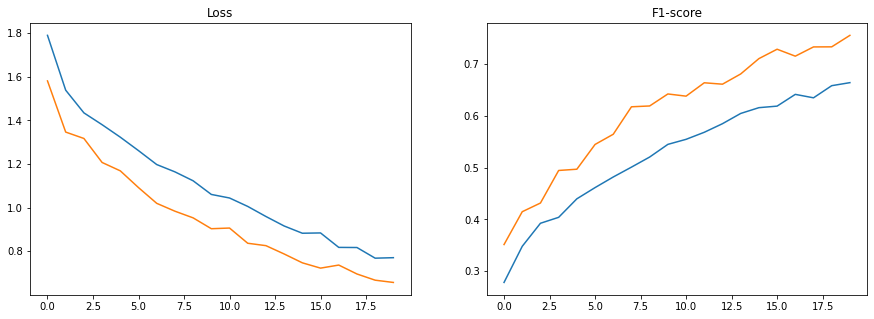

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_history["train"])
ax[0].plot(loss_history["val"])
ax[0].set_title("Loss")

ax[1].plot(f1_history["train"])
ax[1].plot(f1_history["val"])
ax[1].set_title("F1-score")

In [259]:
def predict(model, dataloader):
    predictions = []
    with torch.no_grad():
        model.eval()
        for data, _ in tqdm(dataloader):
            data = data.to(device)

            output = model(data)
            # preds = preds = output.argmax(-1)
            preds = output
            preds = preds.to("cpu").to(torch.float32).numpy()
            predictions.append(preds)

    predictions = np.concatenate(predictions)
    return predictions

In [240]:
img_dir="/content/images/images"

In [251]:
train_whole_dataset = ImgDataset(dataset, img_dir, transform)
dataloader = DataLoader(train_whole_dataset, batch_size=24)

### Сохраняем эмбединги картинок для нашей задачи

In [256]:
model._fc = model._fc[:5]
model._fc

Sequential(
  (0): Linear(in_features=1792, out_features=896, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=896, out_features=448, bias=True)
)

In [258]:
input, target = next(iter(dataloader))
model(input.to(device)).shape

torch.Size([24, 448])

In [260]:
predictions = predict(model, dataloader)









  0%|          | 0/301 [00:00<?, ?it/s]







  0%|          | 1/301 [00:00<03:39,  1.36it/s]







  1%|          | 2/301 [00:01<03:41,  1.35it/s]







  1%|          | 3/301 [00:02<03:38,  1.36it/s]







  1%|▏         | 4/301 [00:02<03:37,  1.37it/s]







  2%|▏         | 5/301 [00:03<03:35,  1.37it/s]







  2%|▏         | 6/301 [00:04<03:33,  1.38it/s]







  2%|▏         | 7/301 [00:05<03:31,  1.39it/s]







  3%|▎         | 8/301 [00:05<03:29,  1.40it/s]







  3%|▎         | 9/301 [00:06<03:28,  1.40it/s]







  3%|▎         | 10/301 [00:07<03:26,  1.41it/s]







  4%|▎         | 11/301 [00:07<03:24,  1.42it/s]







  4%|▍         | 12/301 [00:08<03:23,  1.42it/s]







  4%|▍         | 13/301 [00:09<03:23,  1.42it/s]







  5%|▍         | 14/301 [00:10<03:22,  1.42it/s]







  5%|▍         | 15/301 [00:10<03:21,  1.42it/s]







  5%|▌         | 16/301 [00:11<03:21,  1.41it/s]







  6%|▌         | 17/301 [00:12<03:22,  1.40it/s]







  

In [261]:
predictions.shape

(7223, 448)

In [263]:
np.save("/content/gdrive/MyDrive/train_img_dataset.npy", predictions)

In [247]:
len(train_whole_dataset)

7223

# Тренируем трансофрмер на тексте

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, XLMRobertaTokenizer, XLMRobertaForSequenceClassification

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('youscan/ukr-roberta-base')
# model = RobertaForSequenceClassification.from_pretrained('youscan/ukr-roberta-base', num_labels=7)
model = RobertaForSequenceClassification.from_pretrained('/content/gdrive/MyDrive/results/checkpoint-8632', num_labels=7)

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset["combined"].to_list(), dataset["source"].to_list(), test_size=.2)

In [ ]:
train_encodings = tokenizer(dataset["text"].to_list(), truncation=True, padding=True)
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
train_labels = dataset["source"].to_list()

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
# val_dataset = NewsDataset(val_encodings, val_labels)
# test_dataset = NewsDataset(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import f1_score
from functools import partial

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = f1_score(labels, preds, average="macro")
  return {
      'accuracy': acc,
  }

### Тренируем модель, а потом отрезаем от нее последнюю часть и сохраняем эмбединги

In [ ]:
model.classifier.dropout = torch.nn.Identity()
model.classifier.out_proj = torch.nn.Identity()
model.classifier

RobertaClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Identity()
  (out_proj): Identity()
)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=8,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    # eval_dataset=val_dataset,           # evaluation dataset
    compute_metrics=compute_metrics
)
    
# trainer.train()

In [ ]:
class NewsDatasetEval(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = NewsDatasetEval(train_encodings)

In [ ]:
res = trainer.predict(train_dataset)
res[2]

In [ ]:
trainer.evaluate()

{'epoch': 8.0,
 'eval_accuracy': 0.9504395129790767,
 'eval_loss': 0.3210756182670593,
 'eval_mem_cpu_alloc_delta': 189804,
 'eval_mem_cpu_peaked_delta': 265858,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 434414592,
 'eval_runtime': 120.2926,
 'eval_samples_per_second': 26.901}

In [ ]:
!unzip test_without_target.csv.zip test_without_target.csv

Archive:  test_without_target.csv.zip
  inflating: test_without_target.csv  


In [264]:
test_data = pd.read_csv("test_without_target.csv")
# test_data["title"] = test_data["title"].fillna("")
# test_data["combined"] = test_data["title"] + " " + test_data["text"]
test_data.head()

,Id,title,text,images
0,0,Падіння економіки в Україні не є критичним - ЄБРР,Падіння економічного рівня в Україні не є крит...,NaN
1,3,Геймерам віддають безкоштовно шутер Rage 2 та ...,Шутер Rage 2 віддають безкоштовно в EGS / фото...,NaN
2,4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc..."
3,6,Індекс Dow Jones вперше перевищив 30 тисяч пун...,На тлі новин щодо передачі влади у США та вакц...,NaN
4,7,Трамп і Меркель обговорили підтримку економічн...,Президент США Дональд Трамп і канцлерка Німечч...,NaN


In [270]:
idx = test_data["images"].dropna().index
test_data = test_data.loc[idx]
test_data["source"] = 0
test_data

,Id,title,text,images,source
2,4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc...",0
5,8,"""Не містить живого вірусу"": у МОЗ розвінчали ф...","Вакцини не містять живого вірусу, запевняють у...",e3a6e723-c5d8-4fed-89fe-bfed99296d86.png,0
7,19,МОЗ рекомендує школам проводити заняття на сві...,У Міністерстві охорони здоров'я рекомендують о...,1d15bcb5-cf61-4002-b965-a1e38a1663ec.png,0
9,29,У ТКГ спрогнозували нове загострення на Донбас...,Ситуація на Донбасі загострюється / фото [SOUR...,3447d664-787f-4801-aa58-c78878e433da.png,0
11,31,Держдеп США нагородить білоруську опозиціонерк...,Серед лауреатів на премію Державного департаме...,6fbaa3c9-a138-4471-9b86-dc11d2daf64a.png,0
...,...,...,...,...,...
16176,32359,"Ситуація ""тривожна"" - мер Києва про поширення ...",У столиці різко зросла кількість нових випадкі...,"7a03b971-8db4-41e3-8dcc-26bb35d1a9d0.png,e70db...",0
16179,32363,Вчителька вдарила школярку по голові і відпові...,У Первомайському ліцеї №7 Харківської області ...,0445f65f-358a-4fbb-b8a3-efe5056afba1.png,0
16180,32364,"""Не розслабляємося"": українців просять святкув...",Президент Володимир Зеленський попросив україн...,"3958be83-2e91-4533-aea5-f3299b8f0f86.png,d6d8f...",0
16181,32370,"Флот, торгівля та крок до безвізу: про що домо...",Експорт з України до Великої Британії не постр...,"5389afe0-1914-4ef9-ba9f-e2c9361f5fd8.png,3b093...",0


In [271]:
test_whole_dataset = ImgDataset(test_data, img_dir, transform)
dataloader = DataLoader(test_whole_dataset, batch_size=24)

In [272]:
predictions = predict(model, dataloader)











  0%|          | 0/302 [00:00<?, ?it/s]









  0%|          | 1/302 [00:00<03:51,  1.30it/s]









  1%|          | 2/302 [00:01<03:51,  1.29it/s]









  1%|          | 3/302 [00:02<03:49,  1.31it/s]









  1%|▏         | 4/302 [00:03<03:51,  1.29it/s]









  2%|▏         | 5/302 [00:03<03:49,  1.30it/s]









  2%|▏         | 6/302 [00:04<03:47,  1.30it/s]









  2%|▏         | 7/302 [00:05<03:46,  1.30it/s]









  3%|▎         | 8/302 [00:06<03:46,  1.30it/s]









  3%|▎         | 9/302 [00:06<03:47,  1.29it/s]









  3%|▎         | 10/302 [00:07<03:44,  1.30it/s]









  4%|▎         | 11/302 [00:08<03:41,  1.31it/s]









  4%|▍         | 12/302 [00:09<03:41,  1.31it/s]









  4%|▍         | 13/302 [00:09<03:40,  1.31it/s]









  5%|▍         | 14/302 [00:10<03:38,  1.32it/s]









  5%|▍         | 15/302 [00:11<03:38,  1.31it/s]









  5%|▌         | 16/302 [00:12<03:39,  1.30it/s]









  6%|▌         | 17/30

In [273]:
np.save("/content/gdrive/MyDrive/train_img_dataset.npy", predictions)
predictions.shape

(7238, 448)

In [ ]:
test_encodings = tokenizer(test_data["text"].to_list(), truncation=True, padding=True)

In [ ]:
class NewsDatasetEval(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

test_dataset = NewsDatasetEval(test_encodings)

In [ ]:
outputs = trainer.predict(test_dataset)
preds = outputs.predictions.argmax(-1)

Step,Training Loss
500,1.093200
1000,0.559000
1500,0.468200
2000,0.435100
2500,0.446400
3000,0.404000
3500,0.398100
4000,0.395500
4500,0.289500
5000,0.280800


In [ ]:
subm = test_data.copy()
subm = subm.loc[:, ["Id"]]
subm["Predicted"] = preds
subm.head()

,Id,Predicted
0,0,3
1,3,6
2,4,5
3,6,3
4,7,4


In [ ]:
subm.to_csv("subm.csv", index=False)

In [ ]:
!zip -r checkpoint-8632.zip "results/checkpoint-8632"

  adding: results/checkpoint-8632/ (stored 0%)
  adding: results/checkpoint-8632/training_args.bin (deflated 46%)
  adding: results/checkpoint-8632/optimizer.pt (deflated 9%)
  adding: results/checkpoint-8632/scheduler.pt (deflated 50%)
  adding: results/checkpoint-8632/config.json (deflated 54%)
  adding: results/checkpoint-8632/pytorch_model.bin (deflated 7%)
  adding: results/checkpoint-8632/trainer_state.json (deflated 74%)


# Тренируемся на эмбедингах текста и картинок

In [274]:
train_text_data = np.load("/content/gdrive/MyDrive/train_text_dataset.npy")
train_img_data = np.load("/content/gdrive/MyDrive/train_img_dataset.npy")

In [383]:
x = torch.Tensor(train_img_data)
norm = x.norm(p=10, dim=1, keepdim=True)
x_normalized = x.div(norm)
x_normalized.shape

torch.Size([7223, 448])

In [284]:
train_text_data[list(idx)].shape, train_img_data.shape

((7223, 768), (7223, 448))

In [384]:
train_combinded_data = np.concatenate([train_text_data[list(idx)], x_normalized.numpy()], 1)
train_combinded_data.shape

(7223, 1216)

In [290]:
train_labels = dataset.loc[idx, "source"].to_numpy()
train_labels

array([6, 2, 0, ..., 1, 5, 1])

In [396]:
from lightgbm import LGBMClassifier

In [418]:
Lgb = LGBMClassifier(
    n_estimators=90, silent=False, random_state=94, 
    max_depth=5, num_leaves=31, objective='multiclass'
)
fit_model = Lgb.fit(train_combinded_data[:6000], train_labels[:6000])

In [419]:
preds = fit_model.predict(train_combinded_data[6000:])
f1_score(train_labels[6000:], preds, average='macro')

0.9879499960600052

In [406]:
final_preds = fit_model.predict(train_combinded_data)
final_preds.shape

(7223,)

In [407]:
test_text_data = np.load("/content/gdrive/MyDrive/test_text_dataset.npy")
test_img_data = np.load("/content/gdrive/MyDrive/test_img_dataset.npy")

In [408]:
x = torch.Tensor(test_img_data)
norm = x.norm(p=10, dim=1, keepdim=True)
x_normalized = x.div(norm)
x_normalized.shape

torch.Size([7238, 448])

In [409]:
idx = test_data["images"].dropna().index
test_data = test_data.loc[idx]
test_data

,Id,title,text,images,source
2,4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc...",0
5,8,"""Не містить живого вірусу"": у МОЗ розвінчали ф...","Вакцини не містять живого вірусу, запевняють у...",e3a6e723-c5d8-4fed-89fe-bfed99296d86.png,0
7,19,МОЗ рекомендує школам проводити заняття на сві...,У Міністерстві охорони здоров'я рекомендують о...,1d15bcb5-cf61-4002-b965-a1e38a1663ec.png,0
9,29,У ТКГ спрогнозували нове загострення на Донбас...,Ситуація на Донбасі загострюється / фото [SOUR...,3447d664-787f-4801-aa58-c78878e433da.png,0
11,31,Держдеп США нагородить білоруську опозиціонерк...,Серед лауреатів на премію Державного департаме...,6fbaa3c9-a138-4471-9b86-dc11d2daf64a.png,0
...,...,...,...,...,...
16176,32359,"Ситуація ""тривожна"" - мер Києва про поширення ...",У столиці різко зросла кількість нових випадкі...,"7a03b971-8db4-41e3-8dcc-26bb35d1a9d0.png,e70db...",0
16179,32363,Вчителька вдарила школярку по голові і відпові...,У Первомайському ліцеї №7 Харківської області ...,0445f65f-358a-4fbb-b8a3-efe5056afba1.png,0
16180,32364,"""Не розслабляємося"": українців просять святкув...",Президент Володимир Зеленський попросив україн...,"3958be83-2e91-4533-aea5-f3299b8f0f86.png,d6d8f...",0
16181,32370,"Флот, торгівля та крок до безвізу: про що домо...",Експорт з України до Великої Британії не постр...,"5389afe0-1914-4ef9-ba9f-e2c9361f5fd8.png,3b093...",0


In [410]:
test_combinded_data = np.concatenate([test_text_data[list(idx)], x_normalized.numpy()], 1)
test_combinded_data.shape

(7238, 1216)

In [412]:
final_preds = fit_model.predict(test_combinded_data)
final_preds.shape

(7238,)

In [413]:
final_preds

array([5, 6, 5, ..., 0, 4, 0])

In [415]:
# В результат чисто на тексте обновляем предсказания, где есть картинки
subm = pd.read_csv("/content/gdrive/MyDrive/subm-8.csv")
subm.loc[idx, "Predicted"] = final_preds
subm

,Id,Predicted
0,0,3
1,3,6
2,4,5
3,6,3
4,7,4
...,...,...
16178,32362,1
16179,32363,5
16180,32364,0
16181,32370,4


In [417]:
subm.to_csv("subm.csv", index=False)

### Нейронку не получилось обучить

In [427]:
class MultiSourceModel(nn.Module):
  
  def __init__(self, intput_size, output_size, dropout_prob=0.2):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(intput_size, intput_size), 
        nn.ReLU(),
        nn.BatchNorm1d(intput_size),
        nn.Dropout(dropout_prob),
        nn.Linear(intput_size, intput_size),
        nn.ReLU(),
        nn.BatchNorm1d(intput_size),
        nn.Dropout(dropout_prob),
        nn.Linear(intput_size, output_size)
    )

  def forward(self, X):
    return self.net(X)

  def predict(self, X):
    Y_pred = self.forward(X)
    return Y_pred

In [428]:
class MultiSourceDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.inputs[idx]), self.labels[idx]

In [429]:
batch_size = 24
datasets = {
    "train": MultiSourceDataset(train_combinded_data[:7000], train_labels[:7000]),
    "val": MultiSourceDataset(train_combinded_data[7000:], train_labels[7000:])
}
dataloaders = {
    "train": DataLoader(datasets["train"], drop_last=True, batch_size=batch_size),
    "val": DataLoader(datasets["val"], drop_last=True, batch_size=batch_size)
}

In [430]:
final_model = MultiSourceModel(train_combinded_data.shape[1], 7).to(device)

In [431]:
weights_dir = "/content/gdrive/MyDrive/final_weights"

In [432]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [433]:
loss_history, f1_history = train(
    final_model, dataloaders, criterion, optimizer, weights_dir, num_epochs=200
)

Epoch: 0
Improvement-Detected, save-model
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 1
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 2
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 3
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 4
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 5
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 6
train Loss: 1.9335 F1: 0.0907
val Loss: 1.8683 F1: 0.0815
Epoch: 7


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'F1-score')

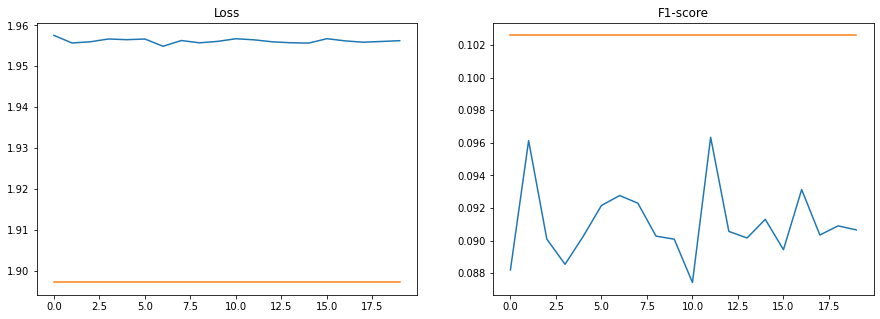

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_history["train"])
ax[0].plot(loss_history["val"])
ax[0].set_title("Loss")

ax[1].plot(f1_history["train"])
ax[1].plot(f1_history["val"])
ax[1].set_title("F1-score")